Вариант: Список людей. 

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import featuretools as ft


# Функция для применения oversampling
def apply_oversampling(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Функция для применения undersampling
def apply_undersampling(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    """
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    """

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test


df = pd.read_csv("../data/age.csv", nrows=100000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Id                 100000 non-null  object 
 1   Name               100000 non-null  object 
 2   Short description  99923 non-null   object 
 3   Gender             98015 non-null   object 
 4   Country            94533 non-null   object 
 5   Occupation         97299 non-null   object 
 6   Birth year         100000 non-null  int64  
 7   Death year         99999 non-null   float64
 8   Manner of death    14821 non-null   object 
 9   Age of death       99999 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 7.6+ MB


Такую информацию могут использовать компании связанные с историей/культурой, с GameDev-ом, с созданием кинематографа. Реальные имена могут сделать тот же фильм более историчным. 

Как бизнес-цели выделим следующие 2 варианта:
    1) GameDev. Создание игры про конкретного персонажа, живущего в конкретном временном промежутке в конкретной стране. 
    2) Исследование зависимости длительности жизни от страны проживания.
    

Поскольку данные не полные, их необходимо заполнить стандартными значениями:

In [9]:
print(df.isnull().sum())

Id                       0
Name                     0
Short description       77
Gender                1985
Country               5467
Occupation            2701
Birth year               0
Death year               1
Manner of death      85179
Age of death             1
dtype: int64


In [10]:
df.fillna({"Gender": "NaN", "Country": "NaN", "Occupation" : "NaN", "Manner of death" : "NaN"}, inplace=True)
df = df.dropna()
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 99922 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 99922 non-null  object 
 1   Name               99922 non-null  object 
 2   Short description  99922 non-null  object 
 3   Gender             99922 non-null  object 
 4   Country            99922 non-null  object 
 5   Occupation         99922 non-null  object 
 6   Birth year         99922 non-null  int64  
 7   Death year         99922 non-null  float64
 8   Manner of death    99922 non-null  object 
 9   Age of death       99922 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 8.4+ MB


Id                   Name  \
99995  Q729652  Jacques-Joseph Moreau   
99996  Q729661         Jerome Wiesner   
99997  Q729662     Westmoreland Davis   
99998  Q729674           John Needham   
99999  Q729679         Francis Bourne   

                                 Short description Gender  \
99995                          French psychiatrist   Male   
99996                   American academic engineer   Male   
99997              American politician (1859-1942)   Male   
99998  English biologist and Roman Catholic priest   Male   
99999                            Catholic cardinal   Male   

                        Country                  Occupation  Birth year  \
99995                    France  Psychiatrist; psychologist        1804   
99996  United States of America                  Researcher        1915   
99997  United States of America                  Politician        1859   
99998                   England            Religious figure        1713   
99999            United Kingdom            Religious figure        1861   

       Death year Manner of death  Age of death  
99995      1884.0             NaN          80.0  
99996      1994.0             NaN          79.0  
99997      1942.0             NaN          83.0  
99998      1810.0             NaN          97.0  
99999      1934.0             NaN          73.0

Данные приращены, удалены только те строки, в которых не было даты смерти или короткого описания

<Axes: ylabel='Frequency'>

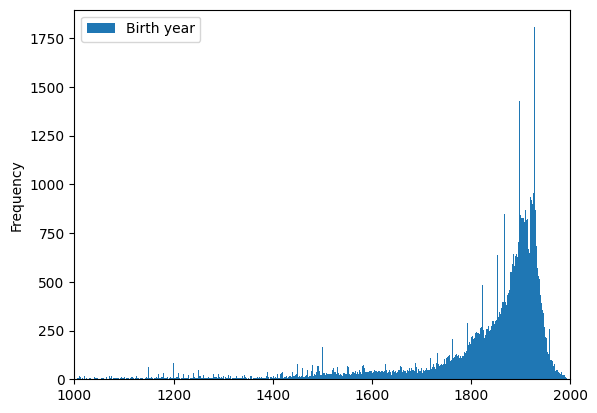

In [11]:
df.plot.hist(column=["Birth year"], xlim=(1000, 2000), bins=4000)

Помимо этого обработаем колонку страны таким образом, что каждый человек, который жил не в одной стране, будет занимать более одной строки, в соответствии с количеством стран в которых он жил.

In [12]:
df['Country'] = df['Country'].str.split('; ')
df = df.explode('Country')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116555 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Id                 116555 non-null  object 
 1   Name               116555 non-null  object 
 2   Short description  116555 non-null  object 
 3   Gender             116555 non-null  object 
 4   Country            116555 non-null  object 
 5   Occupation         116555 non-null  object 
 6   Birth year         116555 non-null  int64  
 7   Death year         116555 non-null  float64
 8   Manner of death    116555 non-null  object 
 9   Age of death       116555 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 9.8+ MB


Далее выполним разбиение на обучающую, контрольную и тестовую выборки.

In [15]:
data = df.copy()

value_counts = data["Country"].value_counts()
rare = value_counts[value_counts < 50].index
data = data[~data["Country"].isin(rare)]

print(len(data["Country"].unique()))

        
df_train, df_val, df_test = split_stratified_into_train_val_test(
    data, stratify_colname="Country", frac_train=0.60, frac_val=0.20, frac_test=0.20)

print("Обучающая выборка: ", df_train.shape)
print(df_train["Country"].value_counts())

print("Контрольная выборка: ", df_val.shape)
print(df_val["Country"].value_counts())

print("Тестовая выборка: ", df_test.shape)
print(df_test["Country"].value_counts())

121
Обучающая выборка:  (67038, 10)
Country
Germany                       15128
United States of America       8946
France                         4715
NaN                            3248
United Kingdom                 2796
                              ...  
Song dynasty                     32
Paraguay                         31
Kingdom of Sardinia              31
Confederation of the Rhine       30
Kingdom of Saxony                30
Name: count, Length: 121, dtype: int64
Контрольная выборка:  (22346, 10)
Country
Germany                       5043
United States of America      2982
France                        1572
NaN                           1082
United Kingdom                 932
                              ... 
Vietnam                         11
Paraguay                        10
Kingdom of Saxony               10
Confederation of the Rhine      10
Kingdom of Sardinia             10
Name: count, Length: 121, dtype: int64
Тестовая выборка:  (22347, 10)
Country
Germany         

В данных были удалены строки, у которых были "редкие" страны. Данные наращивать не будем, поскольку в этом нет необходимости


Выполним конструирование признаков. 

Начнем с унитарного кодирования категориальных признаков. Под этот пункт подходит столбец страна

In [16]:
encoder = OneHotEncoder(sparse_output=False, drop="first")

encoded_values = encoder.fit_transform(data[["Country"]])

encoded_columns = encoder.get_feature_names_out(["Country"])

encoded_values_df = pd.DataFrame(encoded_values, columns=encoded_columns)

encoded_values_df


Country_Albania  Country_Argentina  Country_Australia  \
0                   0.0                0.0                0.0   
1                   0.0                0.0                0.0   
2                   0.0                0.0                0.0   
3                   0.0                0.0                0.0   
4                   0.0                0.0                0.0   
...                 ...                ...                ...   
111726              0.0                0.0                0.0   
111727              0.0                0.0                0.0   
111728              0.0                0.0                0.0   
111729              0.0                0.0                0.0   
111730              0.0                0.0                0.0   

        Country_Austria  Country_Austria-Hungary  Country_Austrian Empire  \
0                   0.0                      0.0                      0.0   
1                   0.0                      0.0                      0.0   
2                   0.0                      0.0                      0.0   
3                   0.0                      0.0                      0.0   
4                   0.0                      0.0                      0.0   
...                 ...                      ...                      ...   
111726              0.0                      0.0                      0.0   
111727              0.0                      0.0                      0.0   
111728              0.0                      0.0                      0.0   
111729              0.0                      0.0                      0.0   
111730              0.0                      0.0                      0.0   

        Country_Belgium  Country_Bolivia  Country_Brazil  Country_British Raj  \
0                   0.0              0.0             0.0                  0.0   
1                   0.0              0.0             0.0                  0.0   
2                   0.0              0.0             0.0                  0.0   
3                   0.0              0.0             0.0                  0.0   
4                   0.0              0.0             0.0                  0.0   
...                 ...              ...             ...                  ...   
111726              0.0              0.0             0.0                  0.0   
111727              0.0              0.0             0.0                  0.0   
111728              0.0              0.0             0.0                  0.0   
111729              0.0              0.0             0.0                  0.0   
111730              0.0              0.0             0.0                  0.0   

        ...  Country_United Kingdom of Great Britain and Ireland  \
0       ...                                                0.0     
1       ...                                                0.0     
2       ...                                                0.0     
3       ...                                                0.0     
4       ...                                                0.0     
...     ...                                                ...     
111726  ...                                                0.0     
111727  ...                                                0.0     
111728  ...                                                0.0     
111729  ...                                                0.0     
111730  ...                                                0.0     

        Country_United States of America  Country_Uruguay  Country_Venezuela  \
0                                    1.0              0.0                0.0   
1                                    0.0              0.0                0.0   
2                                    0.0              0.0                0.0   
3                                    1.0              0.0                0.0   
4                                    0.0              0.0                0.0   
...                             

Далее выполним дискретизацию числовых признаков

In [19]:
labels = ["young", "middle-aged", "old"]
num_bins = 3
hist1, bins1 = np.histogram(data["Age of death"].fillna(data["Age of death"].median()), bins=num_bins)
pd.concat([data["Age of death"], pd.cut(data["Age of death"], list(bins1), labels=labels)], axis=1).head(20)

Age of death Age of death
0          67.0  middle-aged
0          67.0  middle-aged
1          49.0  middle-aged
2          56.0  middle-aged
4          57.0  middle-aged
4          57.0  middle-aged
5          42.0  middle-aged
6          88.0          old
7          86.0          old
8          61.0  middle-aged
9          73.0  middle-aged
9          73.0  middle-aged
10         42.0  middle-aged
12         98.0          old
13         56.0  middle-aged
14         56.0  middle-aged
14         56.0  middle-aged
14         56.0  middle-aged
16         63.0  middle-aged
17         91.0          old

Выполнить  «ручной» синтез признаков в рамках данного набора данных не является возможным.

Масштабирование признаков на основе нормировки и стандартизации в рамках данного набора данных не является необходимым.

Выполним конструирование признаков с применением фреймворка Featuretools. 

In [31]:
data1 = data.drop_duplicates(subset="Id", keep="first")

df_train = pd.DataFrame(data1)

# Создание EntitySet
es = ft.EntitySet(id='death_data')

# Добавление DataFrame в EntitySet
es = es.add_dataframe(
    dataframe_name='deaths',
    dataframe=df_train,
    index='Id',
    make_index=False
)

# Определение примитивов (операций) для конструирования признаков
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name='deaths',
    max_depth=2,
    verbose=1,
    n_jobs=1
)

# Вывод сгенерированных признаков
print(feature_matrix.head())

c:\Users\89176\sourse\MII\Labas\AIM-PIbd-31-Kozyrev-S-S\aimvenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\89176\sourse\MII\Labas\AIM-PIbd-31-Kozyrev-S-S\aimvenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\89176\sourse\MII\Labas\AIM-PIbd-31-Kozyrev-S-S\aimvenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\89176\sourse\MII\Labas\AIM-PIbd-31-Kozyrev-S-S

Built 7 features
Elapsed: 00:00 | Progress: 100%|██████████
     Gender                   Country    Occupation  Birth year  Death year  \
Id                                                                            
Q23    Male  United States of America    Politician        1732      1799.0   
Q42    Male            United Kingdom        Artist        1952      2001.0   
Q91    Male  United States of America    Politician        1809      1865.0   
Q255   Male         Holy Roman Empire        Artist        1770      1827.0   
Q260   Male         Kingdom of France  Egyptologist        1790      1832.0   

     Manner of death  Age of death  
Id                                  
Q23   natural causes          67.0  
Q42   natural causes          49.0  
Q91         homicide          56.0  
Q255             NaN          57.0  
Q260  natural causes          42.0  


Все наборы признаков имеют плохую предсказательную способность, высокую скорость вычисления, малую надежность, корреляцию и цельность. Они не являются информативными, как и сам набор данных